### 1. Import Libraries

In [16]:
import pickle
import pandas as pd
import altair as alt
import networkx as nx
import matplotlib.pyplot as plt

### 2. Load data and inspect first five rows

In [17]:
df = pd.read_csv('dataset.csv')
df.head()

,YEAR,TOURNAMENT,WINNER,RUNNER-UP,WINNER_NATIONALITY,WINNER_ATP_RANKING,RUNNER-UP_ATP_RANKING,WINNER_LEFT_OR_RIGHT_HANDED,TOURNAMENT_SURFACE,WINNER_PRIZE
0,2023,Australian Open,Novak Djokovic,Stefanos Tsitsipas,Serbian,1.0,3.0,right,Plexicushion Prestige,2050000.0
1,2022,U.S. Open,Carlos Alcaraz,Casper Rudd,Spanish,2.0,5.0,right,DecoTurf - outdoors,2600000.0
2,2022,Wimbledon,Novak Djokovic,Nick Kyrgios,Serbian,NaN,25.0,right,Grass / Outdoor,2507460.0
3,2022,French Open,Rafael Nadal,Casper Rudd,Spanish,5.0,8.0,left,Clay,1870000.0
4,2022,Australian Open,Rafael Nadal,Daniil Medvedev,Spanish,5.0,2.0,left,Plexicushion Prestige,4400000.0


### 3. Drop rows before 2003

In [18]:
df.drop(df[df['YEAR'] <= 2003].index, inplace=True)
df.head()
df.to_csv('filtered_data.csv')

# I. Matplotlib

### Initialize the graph
Nodes = players (winner or runner-up) <br>
Edges = finals played between two players, weighted by number of encounters

In [19]:
G = nx.Graph()

for _, row in df.iterrows():
    winner = row['WINNER']
    runner_up = row['RUNNER-UP']
    
    if G.has_edge(winner, runner_up):
        G[winner][runner_up]['weight'] += 1
    else:
        G.add_edge(winner, runner_up, weight=1)



### Create visualization

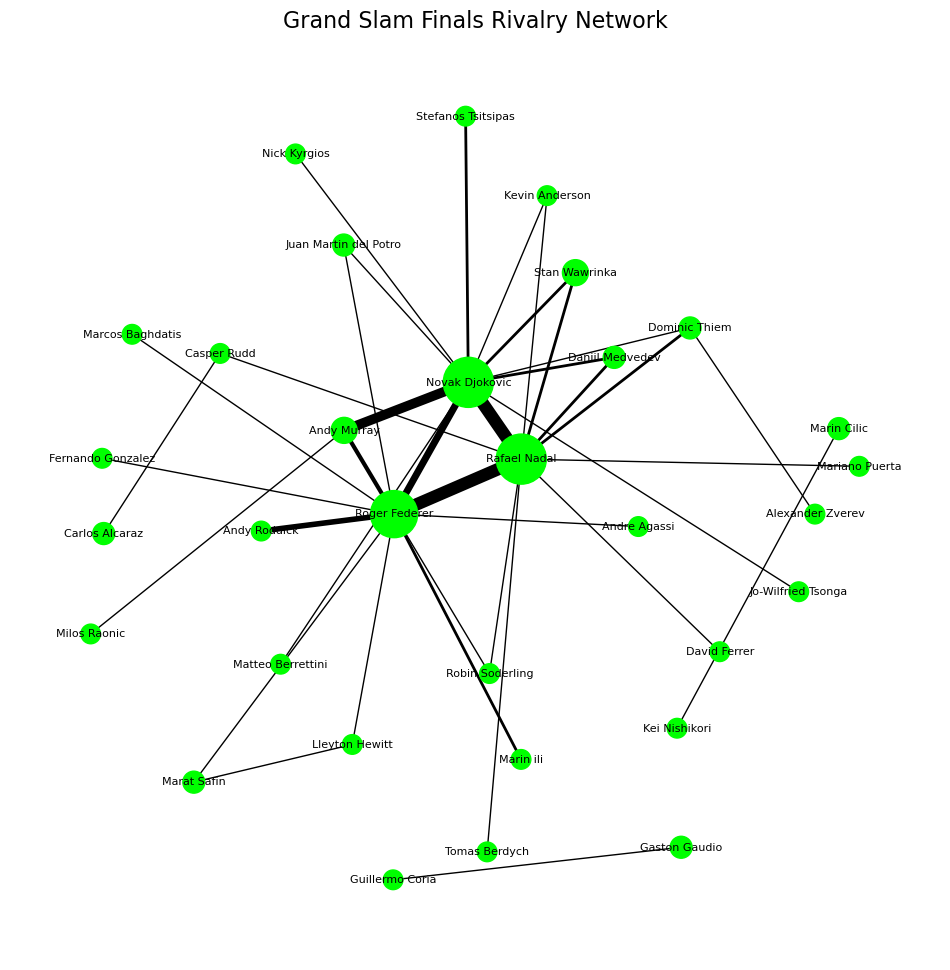

In [20]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=1, seed=22) 


node_sizes = []
for node in G.nodes():
    wins = df[df['WINNER']==node].shape[0]
    node_sizes.append(200 + wins*50)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lime')

weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw_networkx_edges(G, pos, width=[w for w in weights])

nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Grand Slam Finals Rivalry Network", fontsize=16)
plt.axis('off')
plt.show()


### Save positions on graph

In [21]:
with open("positions.pkl", "wb") as f:
    pickle.dump(pos, f)

# II. Altair

### Load positions from Matplotlib/networkx

In [22]:
with open("positions.pkl", "rb") as f:
    pos = pickle.load(f)

### Build edges + nodes

In [23]:
edges = df.groupby(['WINNER', 'RUNNER-UP']).size().reset_index(name='weight')

edges_alt = edges.copy()
edges_alt['x_winner'] = edges_alt['WINNER'].map(lambda p: pos[p][0])
edges_alt['y_winner'] = edges_alt['WINNER'].map(lambda p: pos[p][1])
edges_alt['x_runner'] = edges_alt['RUNNER-UP'].map(lambda p: pos[p][0])
edges_alt['y_runner'] = edges_alt['RUNNER-UP'].map(lambda p: pos[p][1])

nodes = pd.DataFrame(pos).T.reset_index()
nodes.columns = ['player', 'x', 'y']

wins = df.groupby('WINNER').size().reset_index(name='wins')
nodes = nodes.merge(wins, left_on='player', right_on='WINNER', how='left').fillna(0)

### Build graph

In [24]:
edges_chart = alt.Chart(edges_alt).mark_line().encode(
    x='x_winner:Q',
    y='y_winner:Q',
    x2='x_runner:Q',
    y2='y_runner:Q',
    strokeWidth='weight:Q',
    tooltip=['WINNER:N', 'RUNNER_UP:N', 'weight:Q']
).properties(
    width=600,
    height=600
)

nodes_chart = alt.Chart(nodes).mark_circle(color='lime').encode(
    x='x:Q',
    y='y:Q',
    size=alt.Size('wins:Q', scale=alt.Scale(range=[100, 1000])),
    tooltip=['player:N', 'wins:Q']
)

labels = alt.Chart(nodes).mark_text(
    align='center',
    baseline='middle',
    fontSize=10,
    dy=-8   
).encode(
    x='x:Q',
    y='y:Q',
    text='player:N'
)

network_chart = (edges_chart + nodes_chart + labels).encode(
    x=alt.X('x:Q', axis=None),
    y=alt.Y('y:Q', axis=None)    
)
network_chart.interactive()


alt.LayerChart(...)

# III. Synthetic Data Generated from LLM - Deepseek

Prompt for Deepseek: <br>
"Create synthetic data from this dataset. Only randomize the Winner/Runner-Up columns. Use the same set of names, but in a different order. Keep the dataset's structure identical (column names, data types, etc.) Please put it into a csv."

In [25]:
artificial_df = pd.read_csv("artificial_data.csv")
artificial_df.head()

,Unnamed: 0,YEAR,TOURNAMENT,WINNER,RUNNER-UP,WINNER_NATIONALITY,WINNER_ATP_RANKING,RUNNER-UP_ATP_RANKING,WINNER_LEFT_OR_RIGHT_HANDED,TOURNAMENT_SURFACE,WINNER_PRIZE
0,0,2023,Australian Open,Roger Federer,Rafael Nadal,Swiss,1.0,3.0,right,Plexicushion Prestige,2050000.0
1,1,2022,U.S. Open,Stan Wawrinka,Marat Safin,Swiss,2.0,5.0,right,DecoTurf - outdoors,2600000.0
2,2,2022,Wimbledon,Andy Murray,Milos Raonic,British,NaN,25.0,right,Grass / Outdoor,2507460.0
3,3,2022,French Open,Rafael Nadal,Novak Djokovic,Spanish,5.0,8.0,left,Clay,1870000.0
4,4,2022,Australian Open,Novak Djokovic,Andy Murray,Serbian,5.0,2.0,right,Plexicushion Prestige,4400000.0


### IIIa. Matplotlib Re-Draw

In [26]:
G = nx.Graph()

for _, row in artificial_df.iterrows():
    winner = row['WINNER']
    runner_up = row['RUNNER-UP']
    
    if G.has_edge(winner, runner_up):
        G[winner][runner_up]['weight'] += 1
    else:
        G.add_edge(winner, runner_up, weight=1)


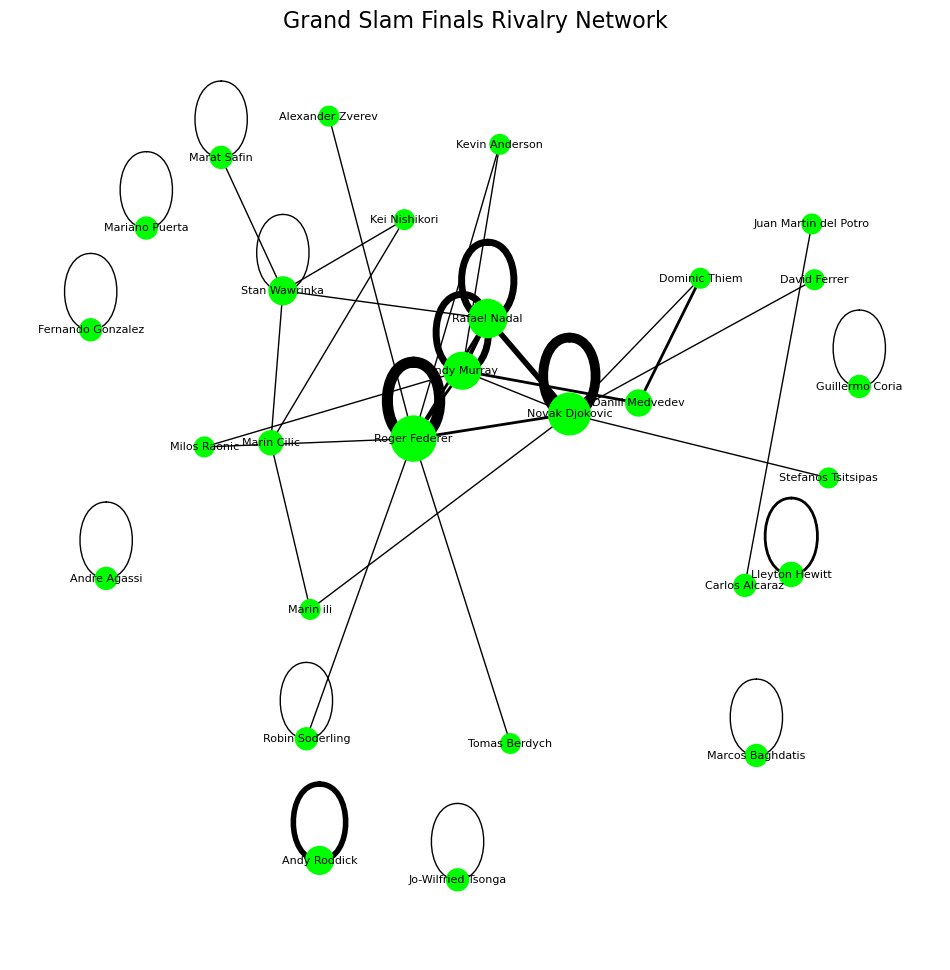

In [27]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=1, seed=22) 


node_sizes = []
for node in G.nodes():
    wins = artificial_df[artificial_df['WINNER']==node].shape[0]
    node_sizes.append(200 + wins*50)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lime')

weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw_networkx_edges(G, pos, width=[w for w in weights])

nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Grand Slam Finals Rivalry Network", fontsize=16)
plt.axis('off')
plt.show()


### Save positions

In [28]:
with open("artificial_positions.pkl", "wb") as f:
    pickle.dump(pos, f)

### IIIb. Altair

In [29]:
with open("artificial_positions.pkl", "rb") as f:
    pos = pickle.load(f)

In [30]:
edges = artificial_df.groupby(['WINNER', 'RUNNER-UP']).size().reset_index(name='weight')

edges_alt = edges.copy()
edges_alt['x_winner'] = edges_alt['WINNER'].map(lambda p: pos[p][0])
edges_alt['y_winner'] = edges_alt['WINNER'].map(lambda p: pos[p][1])
edges_alt['x_runner'] = edges_alt['RUNNER-UP'].map(lambda p: pos[p][0])
edges_alt['y_runner'] = edges_alt['RUNNER-UP'].map(lambda p: pos[p][1])

nodes = pd.DataFrame(pos).T.reset_index()
nodes.columns = ['player', 'x', 'y']

wins = artificial_df.groupby('WINNER').size().reset_index(name='wins')
nodes = nodes.merge(wins, left_on='player', right_on='WINNER', how='left').fillna(0)

In [31]:
edges_chart = alt.Chart(edges_alt).mark_line().encode(
    x='x_winner:Q',
    y='y_winner:Q',
    x2='x_runner:Q',
    y2='y_runner:Q',
    strokeWidth='weight:Q',
    tooltip=['WINNER:N', 'RUNNER_UP:N', 'weight:Q']
).properties(
    width=600,
    height=600
)

nodes_chart = alt.Chart(nodes).mark_circle(color='lime').encode(
    x='x:Q',
    y='y:Q',
    size=alt.Size('wins:Q', scale=alt.Scale(range=[100, 1000])),
    tooltip=['player:N', 'wins:Q']
)

labels = alt.Chart(nodes).mark_text(
    align='center',
    baseline='middle',
    fontSize=10,
    dy=-8   
).encode(
    x='x:Q',
    y='y:Q',
    text='player:N'
)

network_chart = (edges_chart + nodes_chart + labels).encode(
    x=alt.X('x:Q', axis=None),
    y=alt.Y('y:Q', axis=None)    
)
network_chart.interactive()


alt.LayerChart(...)